In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data import DataLoader
from torch.nn.functional import relu

from collections import defaultdict, OrderedDict
from sklearn import metrics


D:\Anaconda\envs\lab\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))

!nvcc --version

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available(), device

Torch 1.13.1+cpu CUDA None
Device: cuda:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Mar_21_19:24:09_Pacific_Daylight_Time_2021
Cuda compilation tools, release 11.3, V11.3.58
Build cuda_11.3.r11.3/compiler.29745058_0


(False, device(type='cpu'))

In [3]:
config = {}

NUM_TARGETS= 3

USER_PATHWAY  = [256, 128, 64]
ITEM_PATHWAY = [256, 128, 64]
COMBINED_PATHWAY = [256, 128, 64, 16]

EMBED_DIM = 40
NUM_ITEM_EMBED = 1378
NUM_USER_EMBED = 47958
NUM_CUPSIZE_EMBED =  12
NUM_CATEGORY_EMBED = 7

NUM_USER_NUMERIC = 5
NUM_ITEM_NUMERIC = 2

DROPOUT = 0.3

EPOCHS = 2
LR = 0.001
WEIGHT_DECAY = 0.0001
BATCH_SIZE = 128


In [4]:
class ModCloth(torch.utils.data.Dataset):
    def __init__(self,datapath):
        self.data = pd.read_csv(datapath)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):

        r = self.data.iloc[idx,:]

        return {
            "user_id" : np.array(r['user_id'], dtype=np.int64),
            "cup_size" : np.array(r['cup_size'], dtype=np.int64),
            "user_numeric" : np.array([r['waist'], r['hips'], r['bra_size'], r['height'], r['shoe_size']], dtype=np.float32),
            "item_id" : np.array(r['item_id'], dtype = np.int64),
            "category" :np.array(r['category'], dtype = np.int64),
            "item_numeric" : np.array([r['size'], r['quality']], dtype=np.float32),
            "fit" : np.array(r['fit'], dtype=np.int64)
        }

datasets = OrderedDict()
splits = ['train', 'valid']
datasets['train'] =  ModCloth("data/modcloth_final_data_processed_train.csv")
datasets['valid'] =  ModCloth("data/modcloth_final_data_processed_valid.csv")
datasets['test'] = ModCloth("data/modcloth_final_data_processed_test.csv")

In [60]:
datasets['test'][0]

{'user_id': array(16027, dtype=int64),
 'cup_size': array(3, dtype=int64),
 'user_numeric': array([-0.04509614, -0.19018778, -0.63570035,  0.6589043 ,  1.2207674 ],
       dtype=float32),
 'item_id': array(102, dtype=int64),
 'category': array(1, dtype=int64),
 'item_numeric': array([-1.0471112,  0.0512912], dtype=float32),
 'fit': array(1, dtype=int64)}

In [50]:
def d4tsne(datasets):
    dataset=[]
    y=[]
    for d in datasets['test']:
        data=[]
        data.append(int(d['cup_size']))
        for i in d['user_numeric']:
            data.append(float(i))

        data.append(int(d['category']))
        for i in d['item_numeric']:
            data.append(float(i))
        dataset.append(data)
        y.append(1 if d['fit']==1 else 0)
    return dataset,y

In [51]:
dataset,y=d4tsne(datasets)

In [33]:
dataset=[]
y=[]
# for d in datasets['train']:
#     data=[]
#     data.append(int(d['cup_size']))
#     for i in d['user_numeric']:
#         data.append(float(i))
    
#     data.append(int(d['category']))
#     for i in d['item_numeric']:
#         data.append(float(i))
#     dataset.append(data)
#     y.append(d['fit'])
# for d in datasets['valid']:
#     data=[]
#     data.append(int(d['cup_size']))
#     for i in d['user_numeric']:
#         data.append(float(i))
    
#     data.append(int(d['category']))
#     for i in d['item_numeric']:
#         data.append(float(i))
#     dataset.append(data)
#     y.append(d['fit'])
for d in datasets['test']:
    data=[]
    data.append(int(d['cup_size']))
    for i in d['user_numeric']:
        data.append(float(i))
    
    data.append(int(d['category']))
    for i in d['item_numeric']:
        data.append(float(i))
    dataset.append(data)
    y.append(1 if d['fit']==1 else 0)

In [34]:
len(dataset)

8279

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [42]:
def tsne_visualization(X,y):
    tsne = TSNE(n_components=2, random_state=0)

    X_tsne = tsne.fit_transform(X)

    colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow']

    for i in np.unique(y):
        plt.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1], color=colors[i], label=i, alpha=0.3, s=5)

    plt.legend()

    plt.show()

C:\Users\asus\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\asus\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


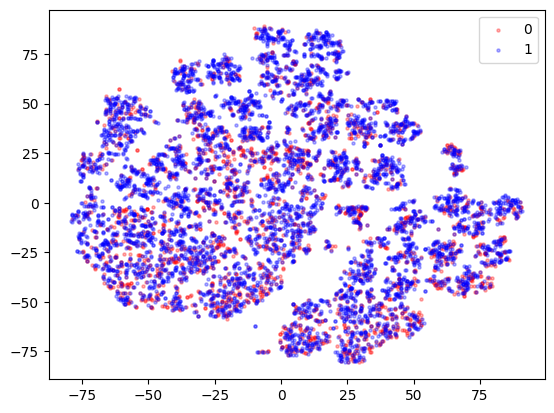

In [45]:
tsne_visualization(dataset,y)

In [46]:
# macro - Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
# weighted - Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

def compute_metrics(target, pred_probs, averaging = "macro"):

    pred_labels = pred_probs.argmax(-1)
    precision = metrics.precision_score(target, pred_labels, average=averaging)
    recall = metrics.recall_score(target, pred_labels, average=averaging)
    f1_score = metrics.f1_score(target, pred_labels, average=averaging)
    accuracy = metrics.accuracy_score(target, pred_labels)
    auc = metrics.roc_auc_score(target, pred_probs, average=averaging, multi_class="ovr")

    return precision, recall, f1_score, accuracy, auc

In [54]:
class Base(nn.Module):
    def __init__(self, user_pathway, item_pathway, combined_pathway, embed_dim, num_item_embed, num_user_embed, num_cupsize_embed, num_category_embed, dropout):
        super().__init__()
       
        self.user_pathway = user_pathway
        self.item_pathway = item_pathway
        self.combined_pathway = combined_pathway
        self.embedding_dim = embed_dim

        self.user_embedding = nn.Embedding(num_user_embed, embed_dim, max_norm=1.0 )
        self.cup_size_embedding = nn.Embedding(num_cupsize_embed, embed_dim, max_norm=1.0 )
        self.item_embedding = nn.Embedding(num_item_embed, embed_dim, max_norm=1.0 )
        self.category_embedding = nn.Embedding(num_category_embed, embed_dim, max_norm=1.0 )


    def forward(self, batch_input):
        # Customer Pathway
        user_emb = self.user_embedding(batch_input["user_id"])
        cup_size_emb = self.cup_size_embedding(batch_input["cup_size"])
        user_representation = torch.cat( [user_emb, cup_size_emb, batch_input["user_numeric"]], dim=-1 )
        user_representation = self.user_transform_blocks(user_representation)

        # Article Pathway
        item_emb = self.item_embedding(batch_input["item_id"])
        category_emb = self.category_embedding(batch_input["category"])
        item_representation = torch.cat( [item_emb, category_emb, batch_input["item_numeric"]], dim=-1 )
        item_representation = self.item_transform_blocks(item_representation)

        # Combine the pathways
        combined_representation = torch.cat( [user_representation, item_representation], dim=-1 )
        combined_representation = self.combined_blocks(combined_representation)

        # Output layer of logits
        logits = self.hidden2output(combined_representation)
        pred_probs = F.softmax(logits, dim=-1)

        return logits, pred_probs, combined_representation

In [55]:
class SFNet(Base):
    def __init__(self, user_pathway, item_pathway, combined_pathway, embed_dim, num_item_embed, num_user_embed, num_cupsize_embed, num_category_embed, dropout):
        super().__init__(user_pathway, item_pathway, combined_pathway, embed_dim, num_item_embed, num_user_embed, num_cupsize_embed, num_category_embed, dropout)

        # Customer pathway transformation  ==  user_embedding_dim + cup_size_embedding_dim + num_user_numeric_features
        user_features_input_size = 2 * self.embedding_dim + NUM_USER_NUMERIC
        self.user_pathway.insert(0, user_features_input_size)
        self.user_transform_blocks = []
        for i in range(1, len(self.user_pathway)):
            self.user_transform_blocks.append( SkipBlock( self.user_pathway[i - 1], self.user_pathway[i] ) )
            self.user_transform_blocks.append(nn.Dropout(DROPOUT))
        self.user_transform_blocks = nn.Sequential(*self.user_transform_blocks)

        # Article pathway transformation == item_embedding_dim + category_embedding_dim + num_item_numeric_features
        item_features_input_size = 2 * self.embedding_dim + NUM_ITEM_NUMERIC
        self.item_pathway.insert(0, item_features_input_size)
        self.item_transform_blocks = []
        for i in range(1, len(self.item_pathway)):
            self.item_transform_blocks.append( SkipBlock( self.item_pathway[i - 1], self.item_pathway[i]) )
            self.item_transform_blocks.append(nn.Dropout(DROPOUT))
        self.item_transform_blocks = nn.Sequential(*self.item_transform_blocks)

        # Combined top layer pathway
        # u = output dim of user_transform_blocks, # t = output dim of item_transform_blocks
        # Pathway combination through [u, t] # Hence, input dimension will be 2*dim(u)
        combined_layer_input_size = 2 * self.user_pathway[-1]
        self.combined_pathway.insert(0, combined_layer_input_size)
        self.combined_blocks = []
        for i in range(1, len(self.combined_pathway)):
            self.combined_blocks.append( SkipBlock( self.combined_pathway[i - 1], self.combined_pathway[i]) )
            self.combined_blocks.append(nn.Dropout(DROPOUT))
        self.combined_blocks = nn.Sequential(*self.combined_blocks)

        # Linear transformation from last hidden layer to output
        self.hidden2output = nn.Linear(self.combined_pathway[-1], NUM_TARGETS)


class SkipBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        """ Skip Connection for feed-forward  - ResNet Block """
        super().__init__()
        self.W1 = nn.Linear(input_dim, output_dim)
        self.W2 = nn.Linear(output_dim, output_dim)
        self.I = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """  z = ReLU(   W2( ReLU( W1(x))) + Projection(x))    """
        z = relu(self.W2(relu(self.W1(x))) + self.I(x))
        return z


In [56]:
class MLP(Base):
    def __init__(self,user_pathway, item_pathway, combined_pathway, embed_dim, num_item_embed, num_user_embed, num_cupsize_embed, num_category_embed, dropout):
        super().__init__(user_pathway, item_pathway, combined_pathway, embed_dim, num_item_embed, num_user_embed, num_cupsize_embed, num_category_embed, dropout)

        # Customer pathway transformation  ==  user_embedding_dim + cup_size_embedding_dim + num_user_numeric_features
        user_features_input_size = 2 * self.embedding_dim + NUM_USER_NUMERIC
        self.user_pathway.insert(0, user_features_input_size)
        self.user_transform_blocks = []
        for i in range(1, len(self.user_pathway)):
            self.user_transform_blocks.append( LinearBlock( self.user_pathway[i - 1], self.user_pathway[i] ) )
        self.user_transform_blocks = nn.Sequential(*self.user_transform_blocks)

        # Article pathway transformation == item_embedding_dim + category_embedding_dim + num_item_numeric_features
        item_features_input_size = 2 * self.embedding_dim + NUM_ITEM_NUMERIC
        self.item_pathway.insert(0, item_features_input_size)
        self.item_transform_blocks = []
        for i in range(1, len(self.item_pathway)):
            self.item_transform_blocks.append( LinearBlock( self.item_pathway[i - 1], self.item_pathway[i])  )
        self.item_transform_blocks = nn.Sequential(*self.item_transform_blocks)

        # Combined top layer pathway
        # u = output dim of user_transform_blocks, # t = output dim of item_transform_blocks
        # Pathway combination through [u, t] # Hence, input dimension will be 4*dim(u)
        combined_layer_input_size = 2 * self.user_pathway[-1]
        self.combined_pathway.insert(0, combined_layer_input_size)
        self.combined_blocks = []
        for i in range(1, len(self.combined_pathway)):
            self.combined_blocks.append( LinearBlock( self.combined_pathway[i - 1], self.combined_pathway[i]) )
        self.combined_blocks = nn.Sequential(*self.combined_blocks)

        # Linear transformation from last hidden layer to output
        self.hidden2output = nn.Linear(self.combined_pathway[-1], NUM_TARGETS)


class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        """ Skip Connection for feed-forward  - ResNet Block """
        super().__init__()
        self.W1 = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """  z = ReLU(   W2( ReLU( W1(x))) + Projection(x))    """
        return relu(self.W1(x))


In [57]:
model = MLP(USER_PATHWAY, ITEM_PATHWAY, COMBINED_PATHWAY, EMBED_DIM, NUM_ITEM_EMBED, NUM_USER_EMBED, NUM_CUPSIZE_EMBED, NUM_CATEGORY_EMBED, DROPOUT)
model = model.to(device)

print("-" * 50)
print(model)

print("-" * 50)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of model parameters: {total_params}")
print("-" * 50)

loss_criterion = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay= WEIGHT_DECAY)

--------------------------------------------------
MLP(
  (user_embedding): Embedding(47958, 40, max_norm=1.0)
  (cup_size_embedding): Embedding(12, 40, max_norm=1.0)
  (item_embedding): Embedding(1378, 40, max_norm=1.0)
  (category_embedding): Embedding(7, 40, max_norm=1.0)
  (user_transform_blocks): Sequential(
    (0): LinearBlock(
      (W1): Linear(in_features=85, out_features=85, bias=True)
    )
    (1): LinearBlock(
      (W1): Linear(in_features=85, out_features=256, bias=True)
    )
    (2): LinearBlock(
      (W1): Linear(in_features=256, out_features=128, bias=True)
    )
    (3): LinearBlock(
      (W1): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (item_transform_blocks): Sequential(
    (0): LinearBlock(
      (W1): Linear(in_features=82, out_features=82, bias=True)
    )
    (1): LinearBlock(
      (W1): Linear(in_features=82, out_features=256, bias=True)
    )
    (2): LinearBlock(
      (W1): Linear(in_features=256, out_features=128, bias=True)
    

In [58]:
step = 0

tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

for epoch in range(EPOCHS):

    for d in datasets:
        for split in splits:
            data_loader = DataLoader( dataset=datasets[split], batch_size=BATCH_SIZE, shuffle = (split == "train") )

            loss_tracker = defaultdict(tensor)

            # Enable/Disable Dropout
            if split == "train":
                model.train()
            else:
                model.eval()
                target_tracker = []
                pred_tracker = []

            for iteration, batch in enumerate(data_loader):

                for k, v in batch.items():
                    batch[k] = v.to(device)

                # Forward pass
                logits, pred_probs,_ = model(batch)

                # loss calculation
                loss = loss_criterion(logits, batch["fit"])   # batch['fit'] are the true labels

                # backward + optimization
                if split == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    step += 1

                # bookkeepeing
                loss_tracker["Total Loss"] = torch.cat((loss_tracker["Total Loss"], loss.view(1)))

                if iteration % 100 == 0 or iteration + 1 == len(data_loader):
                    print(f"{split.upper()} Batch Stats {iteration}/{len(data_loader)}, Loss={loss.item() :.2f}")

                if split == "valid":
                    target_tracker.append(batch["fit"].cpu().numpy())
                    pred_tracker.append(pred_probs.cpu().data.numpy())

            print( f"{split.upper()} Epoch {epoch + 1} / {EPOCHS}, Mean Total Loss {torch.mean(loss_tracker['Total Loss'])}")



TRAIN Batch Stats 0/518, Loss=1.14


KeyboardInterrupt: 

In [61]:
target_tracker = []
pred_tracker = []

print("Preparing test data ...")

data_loader = DataLoader(dataset = datasets['test'], batch_size = BATCH_SIZE, shuffle=False)

print("Evaluating model on test data ...")
model.eval()

embeds1=[]
y1=[]
for d in datasets['test']:
    y1.append(int(d['fit']))

with torch.no_grad():

    for iteration, batch in enumerate(data_loader):

        for k, v in batch.items():
            batch[k] = v.to(device)

        # Forward pass
        _, pred_probs,embeddings = model(batch)
        embeds1.append(embeddings)
        
        target_tracker.append(batch["fit"].cpu().numpy())
        
        pred_tracker.append(pred_probs.cpu().data.numpy())

target_tracker = np.stack(target_tracker[:-1]).reshape(-1)
pred_tracker = np.stack(pred_tracker[:-1], axis=0).reshape(-1, NUM_TARGETS)
precision, recall, f1_score, accuracy, auc = compute_metrics(target_tracker, pred_tracker, averaging = "weighted")

print("-" * 50)
print(f"Metrics:\n Precision = {precision}\n Recall = {recall}\n F1-score = {f1_score}\n Accuracy = {accuracy}\n AUC = {auc}\n ")
print("-" * 50)

Preparing test data ...
Evaluating model on test data ...
--------------------------------------------------
Metrics:
 Precision = 0.4723206162452698
 Recall = 0.687255859375
 F1-score = 0.5598683965100927
 Accuracy = 0.687255859375
 AUC = 0.6369221462640059
 
--------------------------------------------------


C:\Users\asus\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
EPOCHS = 20

model = SFNet(USER_PATHWAY, ITEM_PATHWAY, COMBINED_PATHWAY, EMBED_DIM, NUM_ITEM_EMBED, NUM_USER_EMBED, NUM_CUPSIZE_EMBED, NUM_CATEGORY_EMBED, DROPOUT)
model = model.to(device)

print("-" * 50)
print(model)

print("-" * 50)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of model parameters: {total_params}")
print("-" * 50)

loss_criterion = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay= WEIGHT_DECAY)

In [ ]:
step = 0

tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

for epoch in range(EPOCHS):

    for d in datasets:
        for split in splits:
            data_loader = DataLoader( dataset=datasets[split], batch_size=BATCH_SIZE, shuffle = (split == "train") )

            loss_tracker = defaultdict(tensor)

            # Enable/Disable Dropout
            if split == "train":
                model.train()
            else:
                model.eval()
                target_tracker = []
                pred_tracker = []

            for iteration, batch in enumerate(data_loader):

                for k, v in batch.items():
                    batch[k] = v.to(device)

                # Forward pass
                logits, pred_probs,_ = model(batch)

                # loss calculation
                loss = loss_criterion(logits, batch["fit"])   # batch['fit'] are the true labels

                # backward + optimization
                if split == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    step += 1

                # bookkeepeing
                loss_tracker["Total Loss"] = torch.cat((loss_tracker["Total Loss"], loss.view(1)))

                if iteration % 100 == 0 or iteration + 1 == len(data_loader):
                    print(f"{split.upper()} Batch Stats {iteration}/{len(data_loader)}, Loss={loss.item() :.2f}")

                if split == "valid":
                    target_tracker.append(batch["fit"].cpu().numpy())
                    pred_tracker.append(pred_probs.cpu().data.numpy())

            print( f"{split.upper()} Epoch {epoch + 1} / {EPOCHS}, Mean Total Loss {torch.mean(loss_tracker['Total Loss'])}")



In [62]:
target_tracker = []
pred_tracker = []
embeds2=[]

y2=[]
for d in datasets['test']:
    y2.append(int(d['fit']))

print("Preparing test data ...")

data_loader = DataLoader(dataset = datasets['test'], batch_size = BATCH_SIZE, shuffle=False)

print("Evaluating model on test data ...")
model.eval()
with torch.no_grad():

    for iteration, batch in enumerate(data_loader):

        for k, v in batch.items():
            batch[k] = v.to(device)

        # Forward pass
        _, pred_probs,embeddings = model(batch)
        embeds2.append(embeddings)
        
        target_tracker.append(batch["fit"].cpu().numpy())
        pred_tracker.append(pred_probs.cpu().data.numpy())

target_tracker = np.stack(target_tracker[:-1]).reshape(-1)
pred_tracker = np.stack(pred_tracker[:-1], axis=0).reshape(-1, NUM_TARGETS)
precision, recall, f1_score, accuracy, auc = compute_metrics(target_tracker, pred_tracker, averaging = "weighted")

print("-" * 50)
print(f"Metrics:\n Precision = {precision}\n Recall = {recall}\n F1-score = {f1_score}\n Accuracy = {accuracy}\n AUC = {auc}\n ")
print("-" * 50)

Preparing test data ...
Evaluating model on test data ...
--------------------------------------------------
Metrics:
 Precision = 0.4723206162452698
 Recall = 0.687255859375
 F1-score = 0.5598683965100927
 Accuracy = 0.687255859375
 AUC = 0.6369221462640059
 
--------------------------------------------------


C:\Users\asus\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
y1=[1 if d==1 else 0 for d in y1]
y2=[1 if d==1 else 0 for d in y2]

In [75]:
d1=[]
d2=[]
for e in embeds1:
    for ee in e.tolist():
        d1.append(ee)
for e in embeds2:
    for ee in e.tolist():
        d2.append(ee)

C:\Users\asus\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\asus\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


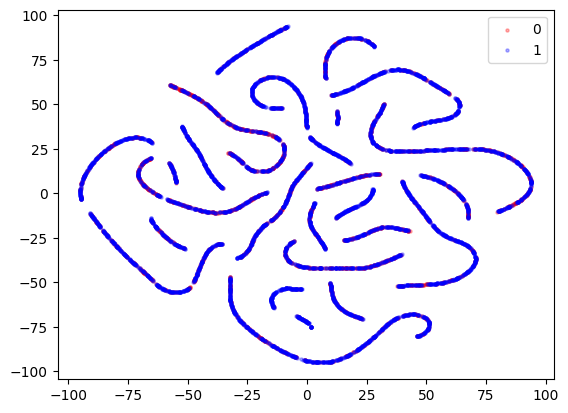

In [76]:
tsne_visualization(d1,y1)

In [73]:
len(embeds1[1].tolist()[0])

16

C:\Users\asus\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\asus\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


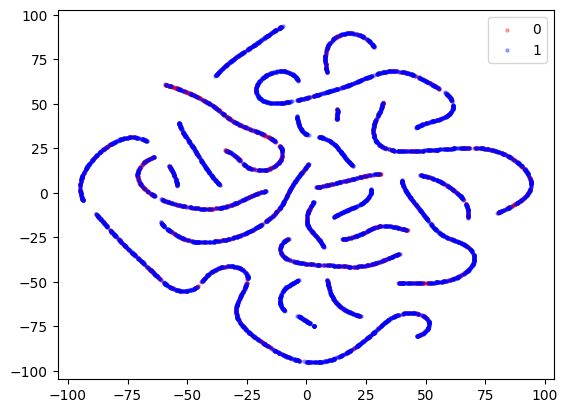

In [77]:
tsne_visualization(d2,y2)